<a href="https://colab.research.google.com/github/shreyash2610/Convolutional-Long-Short-Term-Memory-based-IOT-node-for-Violence-Detection/blob/main/Convolutional_Long_Short_Term_Memory_based_IOT_node_for_Violence_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A bit levelled up for the video classification problems?!

Don't worry, we got you!

Insatlling library for plotting graphs

In [ ]:
!pip install plot-metric

Importing required libraries (majorly used keras and tensorflow)

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sklearn
import matplotlib.pyplot as plt

Of course, picking the modules we gotta play with.

In [ ]:
from glob import glob
from tqdm import tqdm
from keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, ConvLSTM2D,Conv2D,MaxPool2D,GlobalMaxPool2D,GlobalAveragePooling2D,BatchNormalization,Input,TimeDistributed,LSTM,Reshape,GlobalAveragePooling2D
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,roc_curve,confusion_matrix
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from plot_metric.functions import BinaryClassification
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle
from tabulate import tabulate

Easy part gone. Lets get into what is required in problem. 

Okay, has there been any algorithm or model made for video classification???? No, I guess. But I think we heard of something known as CNN which can be applied on images. 

Wait, videos are composed of multiple images or frames, so it can be done by convertig videos into frames keeping in mind to maintain sequence of the frame.

In [ ]:
data_directory = "/content/drive/MyDrive/Violence Detection Dataset/Merged"
img_height,img_width = 112,112
seq_len = 10
classes = ["NonViolence", "Violence"]

In [ ]:
fps=0
frame_count=0
duration=0

Extracting 10 frames from each video to create a dataset

In [ ]:
def frames_extraction(video_path):
    frames_list = []
     
    vidObj = cv2.VideoCapture(video_path)
    global fps 
    fps = vidObj.get(cv2.CAP_PROP_FPS)      
    global frame_count
    frame_count+= int(vidObj.get(cv2.CAP_PROP_FRAME_COUNT))
    global duration
    duration += frame_count/fps 
    count = 1
    total_frames = vidObj.get(cv2.CAP_PROP_FRAME_COUNT)
    frames_step = total_frames//seq_len
    for i in range(seq_len):
        vidObj.set(1,i*frames_step)
        success,image = vidObj.read()   
        if success:
            image = cv2.resize(image, (img_height, img_width))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            frames_list.append(image)
            count += 1
        else:
            print("Defected frame")
            break
            
    return frames_list

In [ ]:
def create_data(input_dir):
    X = []
    Y = []
     
    classes_list = os.listdir(input_dir)
    for c in classes_list:
        print(c)
        files_list = os.listdir(os.path.join(input_dir, c))
        for f in tqdm(files_list):
            frames = frames_extraction(os.path.join(os.path.join(input_dir, c), f))
            if len(frames) == seq_len:
                X.append(frames)
                y = [0]*len(classes)
                y[classes.index(c)] = 1
                Y.append(y)
    print("Frames per second:",fps)
    print("Average number of frames in a video: ",frame_count/4000) 
    X = np.asarray(X)
    Y = np.asarray(Y)
    return X, Y
 
X, Y = create_data(data_directory)

Saving the created data so that you need not to create it again and again.

In [ ]:
np.save('/content/drive/MyDrive/Violence Detection Dataset/X_112_112_10_cnn',X)
np.save('/content/drive/MyDrive/Violence Detection Dataset/Y_112_112_10_cnn',Y)

Loading data

In [ ]:
X=np.load('/content/drive/MyDrive/Violence Detection Dataset/X_112_112_10_cnn.npy')
Y=np.load('/content/drive/MyDrive/Violence Detection Dataset/Y_112_112_10_cnn.npy')

Shuffling data

In [ ]:
X,y = shuffle(X,Y, random_state=42)
print("The shape of input is : ",np.shape(X))
print("The shape of target is : ", np.shape(y))

The shape of input is :  (4000, 10, 112, 112, 3)
The shape of target is :  (4000, 2)


We gonna do 5 folds for the model and then we move forward with model.

Did you miss anything?

Preprocessing?

No, we did it very right now go back to the block where we were trying to generate the frames. Thats the point where we preprocessed frames from BGR to RGB.

In [ ]:
SIZE = (112,112)
CHANNELS = 3
NBFRAME = 10
INSHAPE=(NBFRAME,) + SIZE+ (CHANNELS,)

splits=5
skf = StratifiedKFold(n_splits=splits, shuffle=False)
y=np.argmax(y,axis=1)

Now, a moderate difficult state, the state where we try to create model and doing layers and stuff.

Since we are dumping our final model on raspberry pi, be careful with the number of parameters( not try to exceed 1.2-1.3 million.)

So below is the CNN model, so how are we going to do it sequentially( frames to be passes in sequence) ?

Lets see next block, CNN is bit easy.

In [ ]:
def build_convnet(shape=(112, 112, 3)):
    momentum = .9
    model = Sequential([preprocessing.Rescaling(1.0 / 255),
                              preprocessing.RandomFlip("horizontal"),
                              preprocessing.RandomFlip("vertical"),
                              preprocessing.RandomRotation(0.1),
                              preprocessing.RandomZoom(0.1)])

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())

    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPool2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(GlobalAveragePooling2D())
    return model

Here is the difficult part where we do sequence passing of frames using time distributed layer. And our modelling part is complete.

In [ ]:
def convnet_lstm_model(shape=(NBFRAME,112,112,3), nbout=2):
    convnet = build_convnet(shape[1:])
    model = Sequential()
    model.add(TimeDistributed(convnet, input_shape=shape))
    model.add(LSTM(64))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nbout, activation='softmax'))
    return model

Checking out number of parameters to see if it will fit in raspberry pi.

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = False)

model_convnet = convnet_lstm_model(INSHAPE)
model_convnet.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 128)           1147968   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1024)              66560     
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 1,265,986
Trainable params: 1,264,834
Non-trainable params: 1,152
_________________________________________________________________


Visualizing our model in a flowchart.

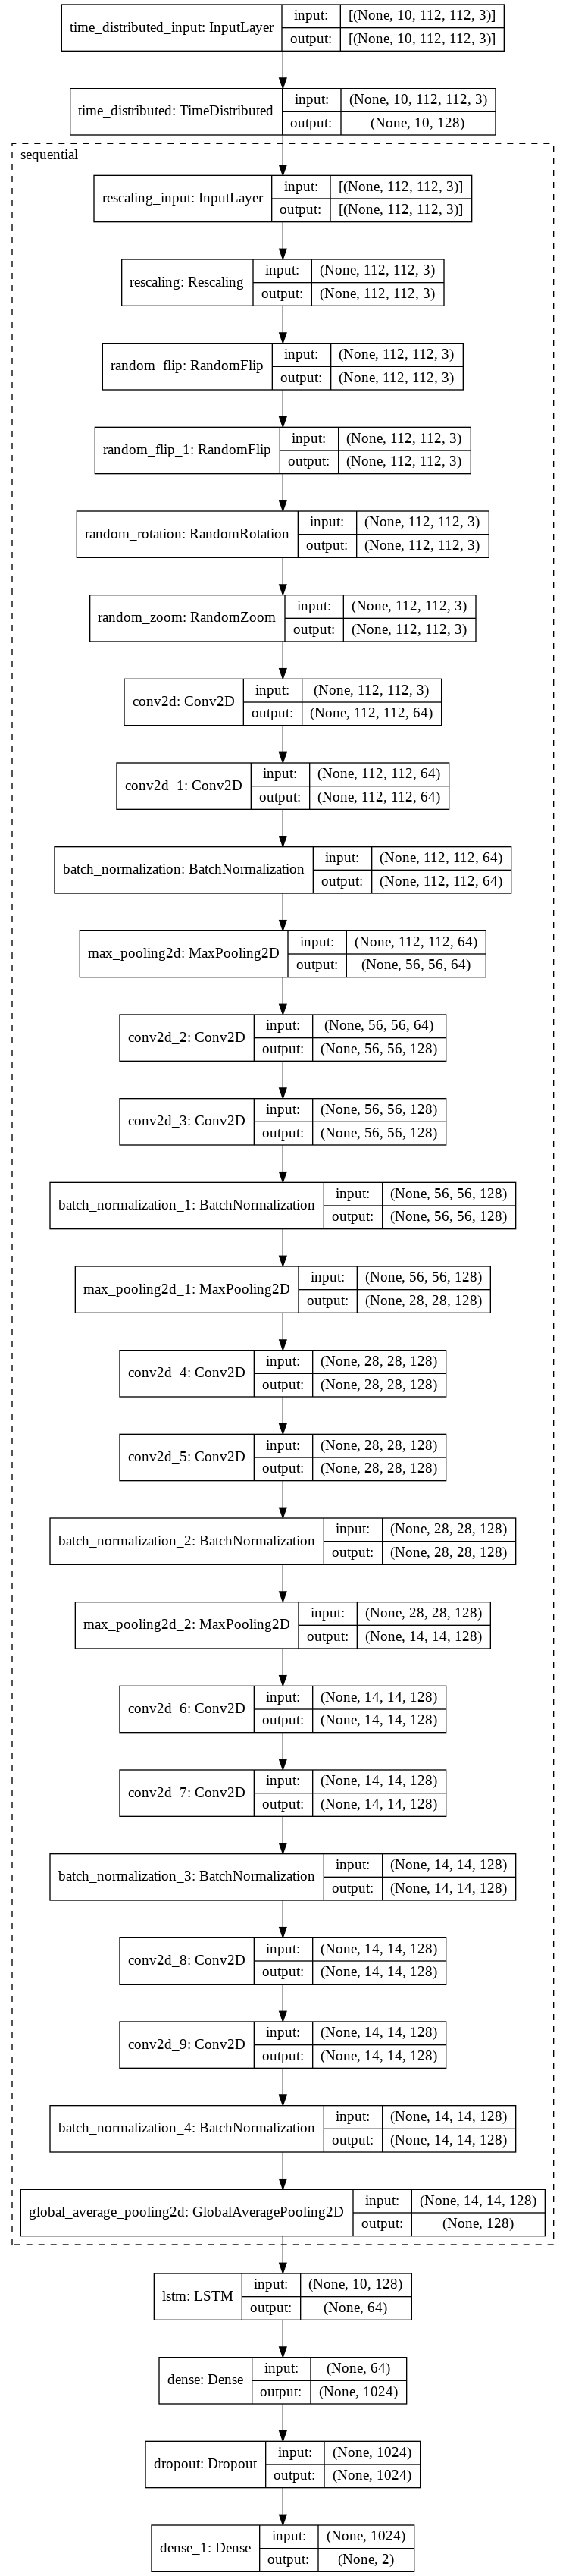

In [ ]:
plot_model(model_convnet,show_shapes=True,expand_nested=True)

Training the model using Adam optimizer on our data to verify training loss and validation loss.

In [ ]:
training_loss=[]
training_accu=[]
valid_accu=[]
valid_loss=[]
pred_targets=[]
Y_test_pf=[]
fold=1
for train_index, test_index in skf.split(X, y):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]
  y_train=np.asarray(pd.get_dummies(y_train))
  y_test=np.asarray(pd.get_dummies(y_test))
  
  model_convnet = convnet_lstm_model(INSHAPE)
  optimizer = keras.optimizers.Adam(1e-4)
  model_convnet.compile(optimizer,'categorical_crossentropy',metrics=['acc'])
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("Fold {}".format(fold))
  history = model_convnet.fit(x=X_train, y=y_train, epochs=50, batch_size = 8,validation_split=0.125,callbacks = [early_stopping_callback])
  print()
  model_evaluation_history = model_convnet.evaluate(X_test,y_test)
  pred_targets.append(model_convnet.predict(X_test))
  
  training_accu.append(history.history['acc'])
  training_loss.append(history.history['loss'])
  valid_accu.append(history.history['val_acc'])
  valid_loss.append(history.history['val_loss'])
  Y_test_pf.append(y_test)
  fold +=1

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
Fold 1
Epoch 1/50
350/350 [==============================] - 45s 73ms/step - loss: 0.6721 - acc: 0.5825 - val_loss: 0.6482 - val_acc: 0.6325
Epoch 2/50
350/350 [==============================] - 25s 71ms/step - loss: 0.6336 - acc: 0.6443 - val_loss: 0.6287 - val_acc: 0.6250
Epoch 3/50
350/350 [==============================] - 25s 71ms/step - loss: 0.6331 - acc: 0.6350 - val_loss: 0.6688 - val_acc: 0.6150
Epoch 4/50
350/350 [==============================] - 25s 71ms/step - loss: 0.6067 - acc: 0.6604 - val_loss: 0.6404 - val_acc: 0.6225
Epoch 5/50
350/350 [==============================] - 25s 71ms/step - loss: 0.5998 - acc: 0.6675 - val_loss: 0.6222 - val_acc: 0.6450
Epoch 6/50
350/350 [=========================

Looks pretty good training been done on dataset. Let's check results!!

#**Convnet + LSTM :**



##**Results:**

Visualizing loss and accuracy graphs.

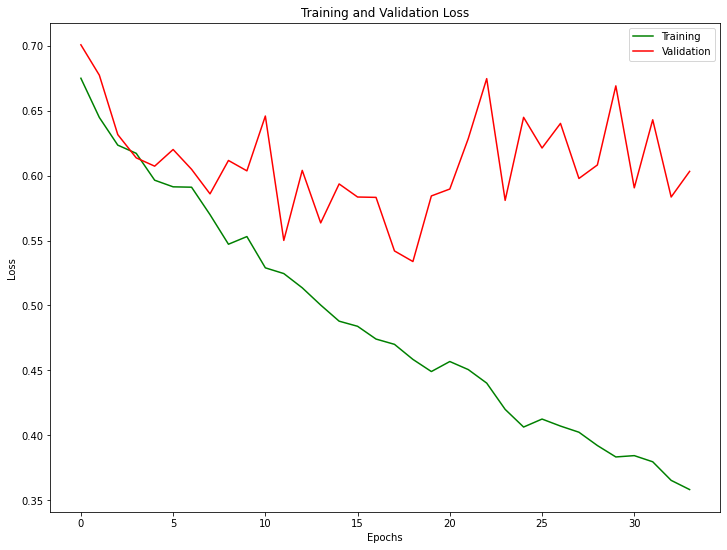

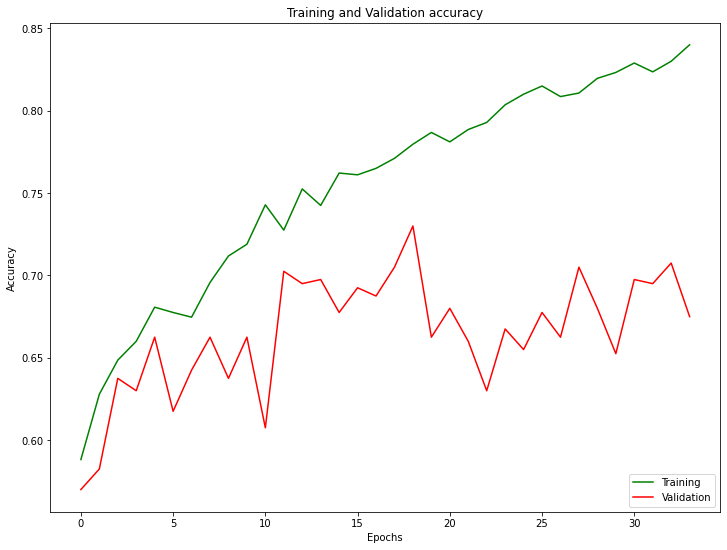

In [ ]:
plt.figure(figsize=(12,9))
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'r')
plt.title('Training and Validation Loss')
plt.legend(["Training","Validation"])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

plt.figure(figsize=(12,9))
plt.plot(history.history['acc'],'g')
plt.plot(history.history['val_acc'],'r')
plt.title('Training and Validation accuracy')
plt.legend(["Training","Validation"],loc="lower right")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

Various metrics such as accuracy, recall, precision, f1-score, roc and etc.

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 1
Correctly predicted out of 800:  597
Accuracy is                   :  0.74625
F1-score is                   :  0.7400768245838668
Recall score is               :  0.7225
Precision score is            :  0.7585301837270341
False Positive Rate           :  0.23
False Negative Rate           :  0.2775
Area under the curve of ROC is:  0.8157812500000001

Report
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       400
           1       0.76      0.72      0.74       400

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.75       800
weighted avg       0.75      0.75      0.75       800



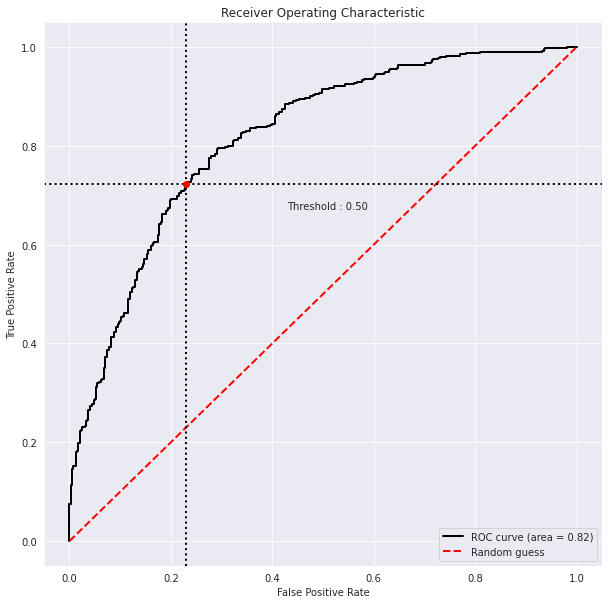

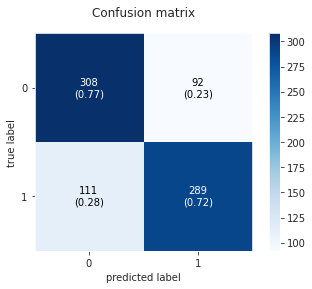

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 2
Correctly predicted out of 800:  582
Accuracy is                   :  0.7275
F1-score is                   :  0.7599118942731279
Recall score is               :  0.8625
Precision score is            :  0.6791338582677166
False Positive Rate           :  0.4075
False Negative Rate           :  0.1375
Area under the curve of ROC is:  0.807509375

Report
              precision    recall  f1-score   support

           0       0.81      0.59      0.68       400
           1       0.68      0.86      0.76       400

    accuracy                           0.73       800
   macro avg       0.75      0.73      0.72       800
weighted avg       0.75      0.73      0.72       800



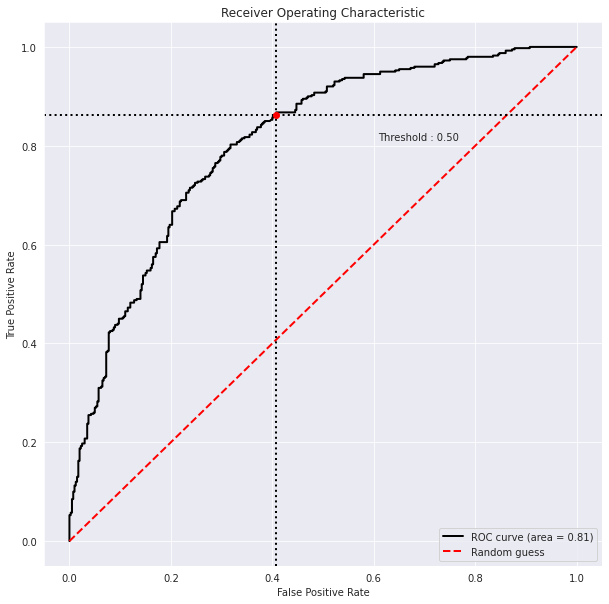

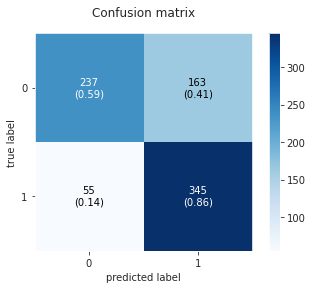

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 3
Correctly predicted out of 800:  583
Accuracy is                   :  0.72875
F1-score is                   :  0.7491329479768787
Recall score is               :  0.81
Precision score is            :  0.6967741935483871
False Positive Rate           :  0.3525
False Negative Rate           :  0.19
Area under the curve of ROC is:  0.8187875000000001

Report
              precision    recall  f1-score   support

           0       0.77      0.65      0.70       400
           1       0.70      0.81      0.75       400

    accuracy                           0.73       800
   macro avg       0.73      0.73      0.73       800
weighted avg       0.73      0.73      0.73       800



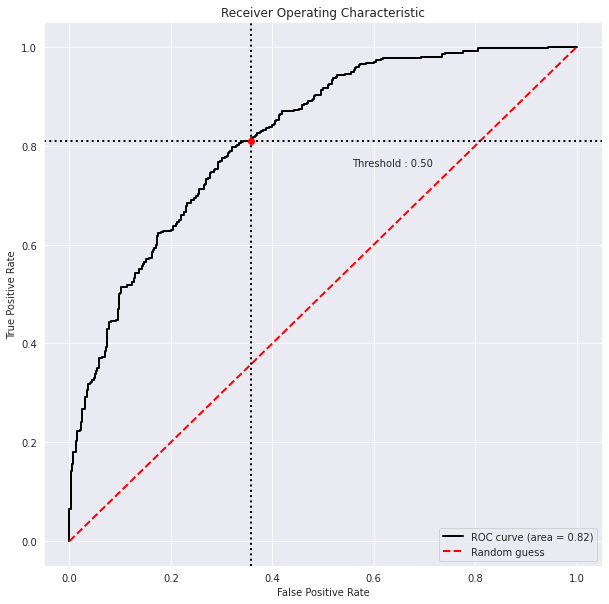

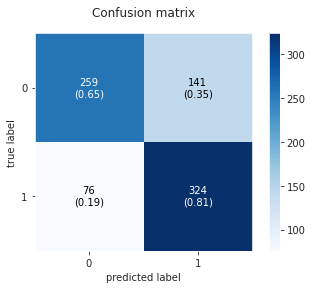

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 4
Correctly predicted out of 800:  612
Accuracy is                   :  0.765
F1-score is                   :  0.7777777777777777
Recall score is               :  0.8225
Precision score is            :  0.7376681614349776
False Positive Rate           :  0.2925
False Negative Rate           :  0.1775
Area under the curve of ROC is:  0.8412562499999999

Report
              precision    recall  f1-score   support

           0       0.80      0.71      0.75       400
           1       0.74      0.82      0.78       400

    accuracy                           0.77       800
   macro avg       0.77      0.77      0.76       800
weighted avg       0.77      0.77      0.76       800



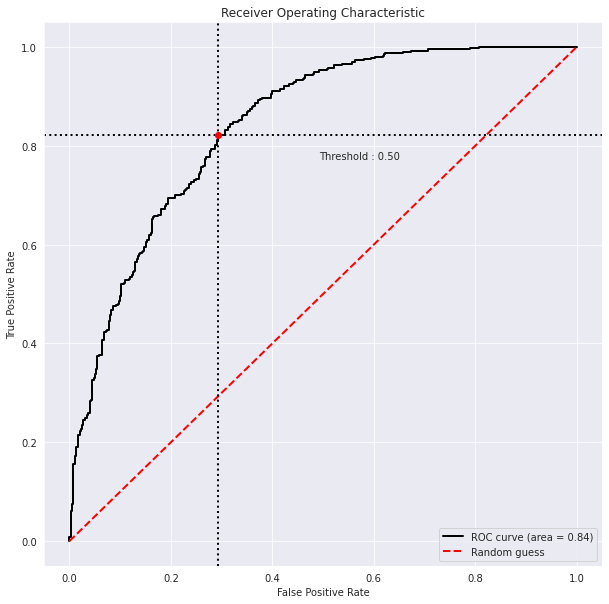

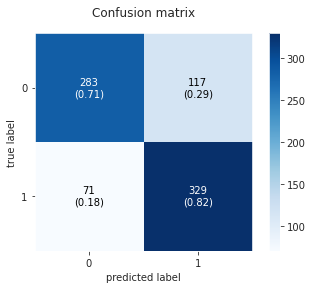

------------------------------------------------------------------------------------------------------------------------------------------
For Fold 5
Correctly predicted out of 800:  574
Accuracy is                   :  0.7175
F1-score is                   :  0.7315914489311164
Recall score is               :  0.77
Precision score is            :  0.6968325791855203
False Positive Rate           :  0.335
False Negative Rate           :  0.23
Area under the curve of ROC is:  0.7967124999999999

Report
              precision    recall  f1-score   support

           0       0.74      0.67      0.70       400
           1       0.70      0.77      0.73       400

    accuracy                           0.72       800
   macro avg       0.72      0.72      0.72       800
weighted avg       0.72      0.72      0.72       800



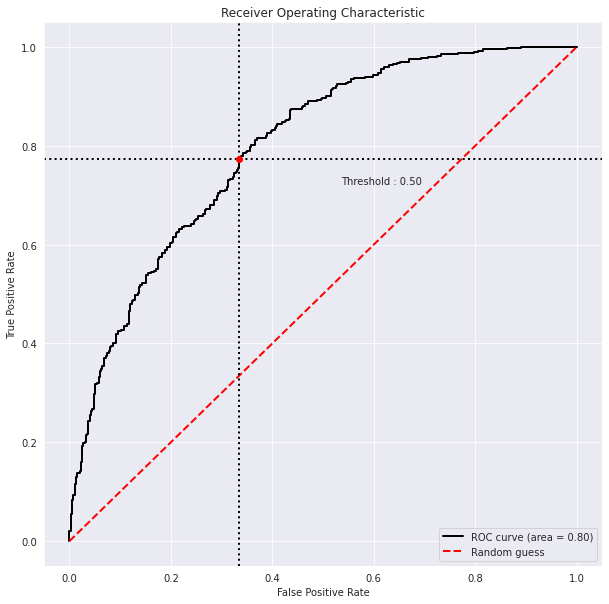

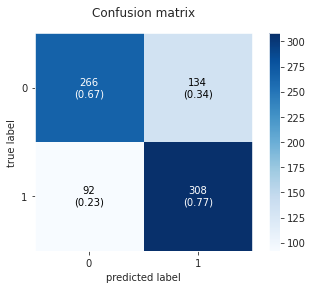

In [ ]:
avg_accuracy=0
avg_recall=0
avg_precision=0
avg_f1=0
avg_fpr=0
avg_fnr=0
table=[]
for i in range(splits):
  print("------------------------------------------------------------------------------------------------------------------------------------------")
  print("For Fold {}".format(i+1))
  
  y_pred=pred_targets[i]
  y_prob=y_pred
  y_pred=np.argmax(y_pred,axis=1)
  Y_test=np.argmax(Y_test_pf[i],axis=1)
  conf_mat=confusion_matrix(Y_test,y_pred)
  table.append(["Fold {}".format(i+1),accuracy_score(Y_test,y_pred),f1_score(Y_test,y_pred),recall_score(Y_test,y_pred),precision_score(Y_test,y_pred),conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0]),conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1])])
  avg_accuracy+=accuracy_score(Y_test,y_pred)
  avg_recall +=recall_score(Y_test,y_pred)
  avg_precision +=precision_score(Y_test,y_pred)
  avg_f1 += f1_score(Y_test,y_pred)
  avg_fpr += conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0])
  avg_fnr += conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1])

  print("Correctly predicted out of 800: ",sum(Y_test==y_pred))
  print("Accuracy is                   : ",accuracy_score(Y_test,y_pred))
  print("F1-score is                   : ",f1_score(Y_test,y_pred))
  print("Recall score is               : ", recall_score(Y_test,y_pred))
  print("Precision score is            : ", precision_score(Y_test,y_pred))
  print("False Positive Rate           : ", conf_mat[0][1]/(conf_mat[0][1]+conf_mat[0][0]))
  print("False Negative Rate           : ", conf_mat[1][0]/(conf_mat[1][0]+conf_mat[1][1]))
  print("Area under the curve of ROC is: ",roc_auc_score(Y_test,y_prob[:,1]))
  print()
  print("Report")
  print(classification_report(Y_test,y_pred))
  bc = BinaryClassification(Y_test, y_prob[:,1], labels=["Class 1", "Class 2"])
  plt.figure(figsize=(10,10))
  bc.plot_roc_curve()
  plt.show()
  fig, ax = plot_confusion_matrix(conf_mat,show_absolute=True,show_normed=True,colorbar=True)
  plt.title("Confusion matrix")
  plt.show()

Average ROC curve for  5 folds for CNN+LSTM.

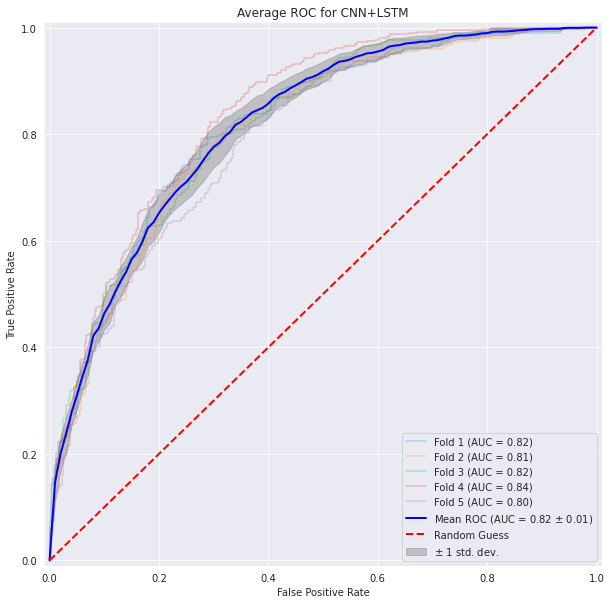

In [ ]:
from sklearn.metrics import auc
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 101)

plt.figure(figsize=(10,10))

for i in range(splits):
    y_prob=pred_targets[i]
    Y_test=np.argmax(Y_test_pf[i],axis=1)
    aucs.append(roc_auc_score(Y_test,y_prob[:,1]))
    fpr,tpr,_ = roc_curve(Y_test, y_prob[:,1])
    plt.plot(fpr, tpr, alpha=0.25, label=r'Fold %d (AUC = %0.2f)' % (i+1, aucs[-1]))
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    

tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = np.maximum(mean_tprs - std,0)

mean_auc=auc(mean_fpr, mean_tprs)
std_auc=np.std(aucs)
plt.plot(mean_fpr, mean_tprs, 'b',lw=2,label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc))
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.4,label=r'$\pm$ 1 std. dev.')
plt.title("Average ROC for CNN+LSTM")
plt.plot([0, 1], [0, 1],'r--',label='Random Guess',lw=2)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc="lower right")
plt.show()

Making table for various folds.

In [ ]:
tbl=np.array(table)
table.append(['Average',(avg_accuracy/splits),(avg_f1/splits),(avg_recall/splits),(avg_precision/splits),(avg_fpr/splits),(avg_fnr/splits)])
table.append(['Standard Deviation',np.std(tbl[:,1].astype('float32')),np.std(tbl[:,2].astype('float32')),np.std(tbl[:,3].astype('float32')),np.std(tbl[:,4].astype('float32')),np.std(tbl[:,5].astype('float32')),np.std(tbl[:,6].astype('float32'))])
print(tabulate(table,headers=["","Accuracy","F1-score","Recall","Precison","FPR","FNR"],tablefmt='github'))
print("")

|                    |   Accuracy |   F1-score |    Recall |   Precison |       FPR |       FNR |
|--------------------|------------|------------|-----------|------------|-----------|-----------|
| Fold 1             |  0.74625   |  0.740077  | 0.7225    |  0.75853   | 0.23      | 0.2775    |
| Fold 2             |  0.7275    |  0.759912  | 0.8625    |  0.679134  | 0.4075    | 0.1375    |
| Fold 3             |  0.72875   |  0.749133  | 0.81      |  0.696774  | 0.3525    | 0.19      |
| Fold 4             |  0.765     |  0.777778  | 0.8225    |  0.737668  | 0.2925    | 0.1775    |
| Fold 5             |  0.7175    |  0.731591  | 0.77      |  0.696833  | 0.335     | 0.23      |
| Average            |  0.737     |  0.751698  | 0.7975    |  0.713788  | 0.3235    | 0.2025    |
| Standard Deviation |  0.0167817 |  0.0160843 | 0.0477232 |  0.0294957 | 0.0595525 | 0.0477232 |

